In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch


from sklearn.model_selection import cross_val_score
import xgboost as xgb
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset

- 1 = true 
- 0 = false

In [45]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
val = pd.read_csv('val.csv')

In [48]:
train = train.dropna()

# Keep only rows where text is a string
train = train[train['text'].apply(lambda x: isinstance(x, str) and x.strip() != '')]
val = val[val['text'].apply(lambda x: isinstance(x, str) and x.strip() != '')]
test = test[test['text'].apply(lambda x: isinstance(x, str) and x.strip() != '')]

In [62]:
train.head()

AttributeError: 'list' object has no attribute 'head'

<Axes: xlabel='label'>

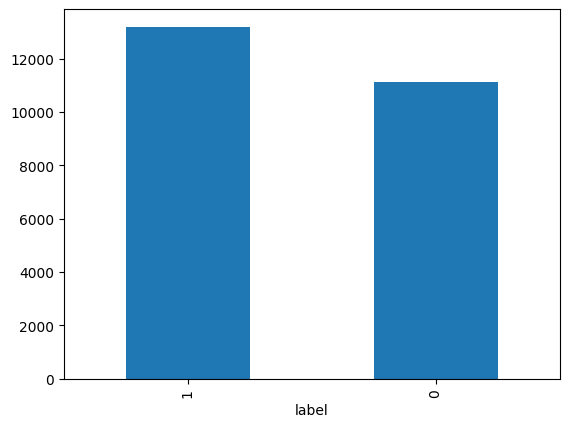

In [49]:
train['label'].value_counts().plot(kind='bar')

In [50]:
# length of the longest sentence
train['length'] = train['text'].apply(lambda x: len(str(x).split()))
longest = train['length'].max()
shortest = train['length'].min()

print(f"Longest sentence: {longest}")
print(f"Shortest sentence: {shortest}")

Longest sentence: 4854
Shortest sentence: 1


In [51]:
X_train = train.drop(['label', 'Unnamed: 0'], axis=1)
y_train = train['label']

X_val = val.drop(['label', 'Unnamed: 0'], axis=1)
y_val = val['label']

X_test = test.drop(['label', 'Unnamed: 0'], axis=1)
y_test = test['label']

In [64]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

In [56]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

In [57]:
train = X_train['text'].to_list()
val = X_val['text'].to_list()
test = X_test['text'].to_list()

In [58]:
train_embeddings = model.encode(train)
val_embeddings = model.encode(val)
test_embeddings = model.encode(test)

In [59]:
print(train_embeddings.shape)

(24321, 768)


In [65]:
print(len(y_train))

24321


In [72]:
learning_rate = np.arange(0.01, 1, 0.05)
train_results = []
val_results = []
for lr in learning_rate:
    model = xgb.XGBClassifier(learning_rate=lr)
    
    # Perform cross-validation on the training set
    cv_scores = cross_val_score(model, train_embeddings, y_train, cv=5)  # 5-fold cross-validation
    
    # Store the mean score from cross-validation
    train_results.append(np.mean(cv_scores))
    
    # Whatfit the model and score on the validation set
    model.fit(train_embeddings, y_train)
    val_score = model.score(val_embeddings, y_val)
    val_results.append(val_score)

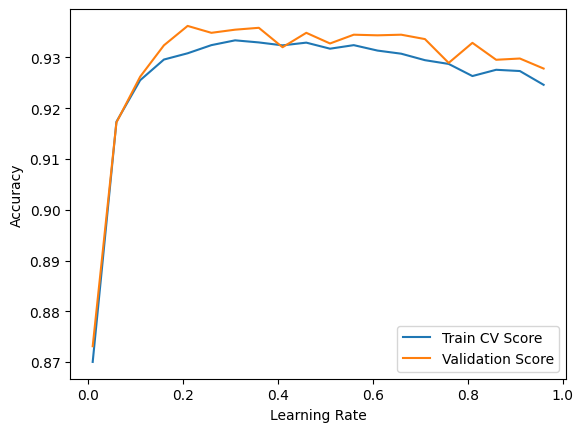

In [73]:
plt.plot(learning_rate, train_results, label='Train CV Score')
plt.plot(learning_rate, val_results, label='Validation Score')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
preds = model.predict(test_embeddings)
print(f"Accuracy: {accuracy_score(y_test, preds)}")
print(f"Precision: {precision_score(y_test, preds)}")
print(f"Recall: {recall_score(y_test, preds)}")
print(f"F1 Score: {f1_score(y_test, preds)}")

Accuracy: 0.9317873442703836
Precision: 0.9381371640407785
Recall: 0.9340253748558247
F1 Score: 0.9360767541324703
